In [13]:
import math
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

from pytorch3d.renderer.points.pulsar import Renderer

In [4]:
device = torch.device("cuda:0")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "flame_pcd.npz")

# Load point cloud
pointcloud = np.load(obj_filename)['samples'].reshape(-1, 3)
verts = torch.Tensor(pointcloud).to(device)
verts.shape

torch.Size([1048576, 3])

In [5]:
point_cloud = Pointclouds(points=[verts])

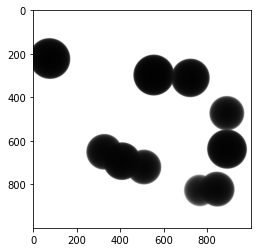

In [23]:
n_points = 10
width = 1_000
height = 1_000
# The PyTorch3D system is right handed; in pulsar you can choose the handedness.
# For easy reproducibility we use a right handed coordinate system here.
renderer = Renderer(width, height, n_points, right_handed_system=True).to(device)
# Generate sample data.
vert_pos = torch.rand(n_points, 3, dtype=torch.float32, device=device) * 10.0
vert_pos[:, 2] += 25.0
vert_pos[:, :2] -= 5.0
vert_col = torch.rand(n_points, 3, dtype=torch.float32, device=device)
vert_col = torch.zeros(n_points, 3, dtype=torch.float32, device=device)
vert_rad = torch.ones(n_points, dtype=torch.float32, device=device)
cam_params = torch.tensor(
    [
        0.0,
        0.0,
        0.0,  # Position 0, 0, 0 (x, y, z).
        0.0,
        math.pi,  # Because of the right handed system, the camera must look 'back'.
        0.0,  # Rotation 0, 0, 0 (in axis-angle format).
        5.0,  # Focal length in world size.
        2.0,  # Sensor size in world size.
    ],
    dtype=torch.float32,
    device=device,
)
# Render.
image = renderer(
    vert_pos,
    vert_col,
    vert_rad,
    cam_params,
    1.0e-1,  # Renderer blending parameter gamma, in [1., 1e-5].
    45.0,  # Maximum depth.
)
img = (image.cpu().detach() * 255.0).to(torch.uint8).numpy()
plt.imshow(img)

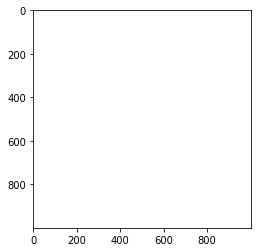

In [24]:
n_points = verts.shape[0]
width = 1_000
height = 1_000
# The PyTorch3D system is right handed; in pulsar you can choose the handedness.
# For easy reproducibility we use a right handed coordinate system here.
renderer = Renderer(width, height, n_points, right_handed_system=True).to(device)
# Generate sample data.
vert_pos = verts
# vert_pos[:, 2] += 25.0
# vert_pos[:, :2] -= 5.0
vert_col = torch.rand(n_points, 3, dtype=torch.float32, device=device)
vert_col = torch.zeros(n_points, 3, dtype=torch.float32, device=device)
vert_rad = torch.ones(n_points, dtype=torch.float32, device=device)
cam_params = torch.tensor(
    [
        0.0,
        0.0,
        0.0,  # Position 0, 0, 0 (x, y, z).
        0.0,
        math.pi,  # Because of the right handed system, the camera must look 'back'.
        0.0,  # Rotation 0, 0, 0 (in axis-angle format).
        5.0,  # Focal length in world size.
        2.0,  # Sensor size in world size.
    ],
    dtype=torch.float32,
    device=device,
)
# Render.
image = renderer(
    vert_pos,
    vert_col,
    vert_rad,
    cam_params,
    1.0e-1,  # Renderer blending parameter gamma, in [1., 1e-5].
    45.0,  # Maximum depth.
)
img = (image.cpu().detach() * 255.0).to(torch.uint8).numpy()
plt.imshow(img)

In [25]:
renderer = PulsarPointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    n_channels=4
).to(device)

images = renderer(point_cloud, gamma=(1e-4,),
                  bg_col=torch.tensor([0.0, 1.0, 0.0, 1.0], dtype=torch.float32, device=device))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

TypeError: 'NoneType' object is not iterable